# Постановка задачи

Необходимо реализовать систему классификации лиц животных. Задача представляет из себя классификацию на 3 класса.

1) Необходимо загрузить изображения и привести их к единому формату. Важно понимать, что исходное разрешение очень больше, и простые сети на несколько слоев могут выдать не такое хорошее качество.

2) Необходимо обучить нейросеть для распознавания 3 классов, желательно будет сравнить результаты на нескольких параметрах.

3) Оценить по метрикам качества для каждого класса.

Важно визуализировать результат прогноза (на тесте) в человеко-читаемом формате с подписью.

Источник данных: https://www.kaggle.com/andrewmvd/animal-faces

# Описание набора данных

Этот набор данных, также известный как Animal Faces-HQ (AFHQ), состоит из 16 130 изображений с разрешением 512×512p.
Есть три класса, каждый из которых содержит около 5000 изображений.

Классы:

*   Кошка
*   Собака
*   Дикое животное

# Импорт и подготовка данных

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# модули библиотеки PyTorch
import torch
from torchvision import datasets, transforms
# модуль, где определены слои для нейронных сетей
import torch.nn as nn
# модуль, где определены активайии для слоев нейронных сетей
import torch.nn.functional as F

# метрика качества
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# импорт архива с изображениями (предварительно загружен на мой google drive)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Далее несколько команд чтобы перейти в папку с архивом на гугл диске, скопировать архив на ssd в папку /content и распаковать файлы

In [ ]:
%cd /content/drive/MyDrive/Data
%ls

/content/drive/MyDrive/Data
animal_faces.zip  creditcard.csv  test.csv   variable_describe_c.csv
BankChurners.csv  heart.csv       train.csv  variable_describe.xlsx


In [ ]:
%cp -r animal_faces.zip /content/

In [ ]:
%cd /content
!unzip animal_faces.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: afhq/train/wild/flickr_wild_001378.jpg  
  inflating: afhq/train/wild/flickr_wild_001379.jpg  
  inflating: afhq/train/wild/flickr_wild_001380.jpg  
  inflating: afhq/train/wild/flickr_wild_001381.jpg  
  inflating: afhq/train/wild/flickr_wild_001382.jpg  
  inflating: afhq/train/wild/flickr_wild_001384.jpg  
  inflating: afhq/train/wild/flickr_wild_001385.jpg  
  inflating: afhq/train/wild/flickr_wild_001386.jpg  
  inflating: afhq/train/wild/flickr_wild_001387.jpg  
  inflating: afhq/train/wild/flickr_wild_001388.jpg  
  inflating: afhq/train/wild/flickr_wild_001389.jpg  
  inflating: afhq/train/wild/flickr_wild_001390.jpg  
  inflating: afhq/train/wild/flickr_wild_001391.jpg  
  inflating: afhq/train/wild/flickr_wild_001392.jpg  
  inflating: afhq/train/wild/flickr_wild_001393.jpg  
  inflating: afhq/train/wild/flickr_wild_001394.jpg  
  inflating: afhq/train/wild/flickr_wild_001395.jpg  
  inflating: a

In [ ]:
# уменьшим размер каждой картинки до 250х250, конвертируем в торч.тензор, нормируем
transform_train = transforms.Compose([
         transforms.Resize((250, 250)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
])
# тоже самое для валидационной выборки
transform_val = transforms.Compose([
         transforms.Resize((250, 250)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
])

In [ ]:
# при загрузке сразу указываем как предобрабатывать
train_data = datasets.ImageFolder("afhq/train/", transform=transform_train)
test_data = datasets.ImageFolder("afhq/val", transform=transform_val)

In [ ]:
torch.cuda.get_device_name()

'Tesla T4'

In [ ]:
# разбиваем на батчи
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle = True, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle = False, pin_memory=True, num_workers=2)

In [ ]:
dataiter = iter(train_loader)
# батч картинок и батч ответов к картинкам
images, labels = dataiter.next()

In [ ]:
# создаем словарь для дальнейшей интерпретации меток классов при их визуализации
class_dict = {
    0: "Cat",
    1: "Dog",
    2: "Wild",
}

Визуализируем случайное изображение

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


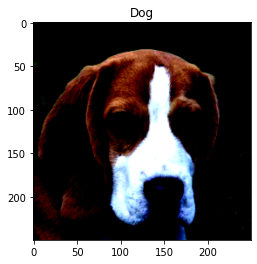

In [ ]:
#получаем случайный индекс по которому вытянем изображение и его лейбл из батча
random_pic_indx = np.random.randint(len(images))

#преобразование тензора в напмай массив
imgarray = images.numpy()# батч 64 элемента 3 250 250

# транспонируем в 250 250 3, т.к. plt требует, чтобы формат массива был H W C
plt_img = np.transpose(images[random_pic_indx],(1,2,0))

#извлечение меток для подписей
current_label = int(labels[random_pic_indx].numpy())
plt.title(class_dict[current_label])

#визуализируем
plt.imshow(plt_img)
plt.show()

#Обучение полносвязной нейронной сети

In [ ]:
# отдаем предпочтение gpu, если недоступно - cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# преобразуем массивы картинок в векторы

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [ ]:
# класс полносвязной нейронки с функцией прямого прохода

class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = Flatten()
        self.fc1 = nn.Linear(250*250*3, 256) # полносвязные слои - вход и выход
        self.fc2 = nn.Linear(256, 3)

    def forward(self, x):
        # forward pass сети

        # переводим входной объект из картинки в вектор
        x = self.flatten(x)
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = F.relu(self.fc1(x))
        # умножение на матрицу весов 2 слоя
        x = self.fc2(x)
        return x

In [ ]:
def train(net, n_epoch=2):
    # выбираем функцию потерь
    loss_fn = torch.nn.CrossEntropyLoss()

    # выбираем алгоритм оптимизации и learning_rate
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # acc по test
    best_accuracy = 0
    # обучаем сеть 2 эпохи
    for epoch in tqdm(range(n_epoch)):

        running_loss = 0.0
        train_dataiter = iter(train_loader)
        for i, batch in enumerate(tqdm(train_dataiter)):
            # так получаем текущий батч
            X_batch, y_batch = batch
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # обнуляем градиент
            optimizer.zero_grad()

            # forward pass (получение ответов на батч картинок)
            y_pred = net(X_batch)
            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(y_pred, y_batch)
            # bаckpropagation (вычисление градиентов)
            loss.backward()
            # обновление весов сети
            optimizer.step()

            # проверяем качество каждые 50 батчей (~пол эпохи)
            if i % 50 ==0:
                # менеджер упарвления контекстом торча указывает на то, чтобы не обновлять параметры
                with torch.no_grad():
                    accuracy = []
                    for batch in test_loader:
                        x, y = batch
                        x = x.to(device)
                        y = y.to(device)
                        y_pred = net(x)
                        # loss = loss_fn(y_pred, y)
                        # находим accuracy батча с теста
                        accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
                    # усредняем accuracy всех батчей на тесте
                    accuracy = np.mean(np.array(accuracy))
                    # если стало лучше - сохраняем на диск и обновляем лучшую метрику
                    if accuracy > best_accuracy:
                        print('New best model with test acc:', accuracy)
                        torch.save(net.state_dict(), './best_model.pt')
                        best_accuracy = accuracy

            # выведем текущий loss
            running_loss += loss.item()
            # выведем качество каждые 50 батчей
            if i % 50 == 0:
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 50))
                running_loss = 0.0

    print('Обучение закончено')
    return net

In [ ]:
# объявляем сеть
net = SimpleNet().to(device)
# обучаем сеть
net = train(net)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

New best model with test acc: 0.5029761904761905
[1,     1] loss: 0.023
New best model with test acc: 0.7038690476190476
[1,    51] loss: 22.235
New best model with test acc: 0.7514880952380952
[1,   101] loss: 8.418
[1,   151] loss: 5.243
New best model with test acc: 0.7560453869047619
[1,   201] loss: 2.765


  0%|          | 0/229 [00:00<?, ?it/s]

New best model with test acc: 0.7739955357142857
[2,     1] loss: 0.018
New best model with test acc: 0.7762276785714285
[2,    51] loss: 1.108
New best model with test acc: 0.7775297619047619
[2,   101] loss: 0.756
New best model with test acc: 0.8096168154761904
[2,   151] loss: 0.662
[2,   201] loss: 0.579
Обучение закончено


In [ ]:
#смотрим accuracy на валидационной выборке
with torch.no_grad():
    accuracy = []
    for batch in test_loader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = net(x)
        accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
    accuracy = np.mean(np.array(accuracy))

print('accuracy', accuracy)

accuracy 0.8085007440476191


#Обучение сверточной нейронной сети

In [ ]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN,self).__init__()

        self.conv1 = nn.Conv2d(3,32,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64,128,kernel_size=3,stride=2,padding=1)
        self.batchnorm2 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1)
        self.batchnorm3 = nn.BatchNorm2d(256)

        self.maxpool = nn.MaxPool2d(2,2)

        self.fc1 = nn.Linear(256 * 2 * 2,512)
        self.fc2 = nn.Linear(512,3)


    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.batchnorm1(x)
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = self.batchnorm2(x)
        x = self.maxpool(x)
        x = F.relu(self.conv4(x))
        x = self.batchnorm3(x)
        x = self.maxpool(x)
        x = x.view(-1, 256 * 2 * 2)
        x = self.fc1(x)
        x = self.fc2(x)
        x = F.log_softmax(x,dim=1)
        return x

In [ ]:
# объявляем сеть
net = CNN().to(device)

# обучаем
net = train(net, n_epoch=5)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

New best model with test acc: 0.326171875
[1,     1] loss: 0.021
New best model with test acc: 0.6383928571428571
[1,    51] loss: 0.939
New best model with test acc: 0.7398623511904763
[1,   101] loss: 0.321
[1,   151] loss: 0.257
New best model with test acc: 0.7700892857142857
[1,   201] loss: 0.200


  0%|          | 0/229 [00:00<?, ?it/s]

[2,     1] loss: 0.003
New best model with test acc: 0.7899925595238096
[2,    51] loss: 0.123
New best model with test acc: 0.8207775297619048
[2,   101] loss: 0.096
[2,   151] loss: 0.128
New best model with test acc: 0.8446800595238096
[2,   201] loss: 0.123


  0%|          | 0/229 [00:00<?, ?it/s]

New best model with test acc: 0.8492373511904763
[3,     1] loss: 0.000
[3,    51] loss: 0.058
New best model with test acc: 0.8643043154761904
[3,   101] loss: 0.056
[3,   151] loss: 0.057
[3,   201] loss: 0.088


  0%|          | 0/229 [00:00<?, ?it/s]

[4,     1] loss: 0.001
[4,    51] loss: 0.053
New best model with test acc: 0.8709077380952381
[4,   101] loss: 0.051
New best model with test acc: 0.8781622023809524
[4,   151] loss: 0.039
[4,   201] loss: 0.038


  0%|          | 0/229 [00:00<?, ?it/s]

[5,     1] loss: 0.000
[5,    51] loss: 0.040
New best model with test acc: 0.8841145833333334
[5,   101] loss: 0.023
New best model with test acc: 0.8859747023809524
[5,   151] loss: 0.019
[5,   201] loss: 0.014
Обучение закончено


In [ ]:
with torch.no_grad():
    accuracy = []
    for batch in test_loader:
        x, y = batch
        # переносим на гпу
        x = x.to(device)
        y = y.to(device)
        # прогнозируем
        y_pred = net(x)
        # loss = loss_fn(y_pred, y)
        # находим accuracy батча с теста
        accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
    # усредняем accuracy всех батчей на тесте
    accuracy = np.mean(np.array(accuracy))

print('Test accuracy', accuracy)

Test accuracy 0.8610491071428571


# Предобученная модель convnext

In [ ]:
from torchvision.models import convnext_base
convnext = convnext_base(pretrained=True)

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth


  0%|          | 0.00/338M [00:00<?, ?B/s]

In [ ]:
convnext.parameters

<bound method Module.parameters of ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate=none)
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_af

In [ ]:
#обрезаем последний слой
convnext.classifier = nn.Sequential(*list(convnext.classifier.children()))[:-1]

In [ ]:
convnext.parameters

<bound method Module.parameters of ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate=none)
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_af

In [ ]:
class New_CONVNEXT(nn.Module):
    def __init__(self):
        super().__init__()
        self.convnext = convnext
        for param in self.convnext.features.parameters(): # отключаем для нее обновление параметров
            param.requires_grad = False
        self.fc = nn.Linear(1024, 3) # добавляем новый слой

    def forward(self, x):
        # forward pass сети
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = self.convnext(x)
        x = self.fc(x)
        return x

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

2689

In [ ]:
#обучение
net = New_CONVNEXT().to(device)
train(net)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

New best model with test acc: 0.6073288690476191
[1,     1] loss: 0.021
New best model with test acc: 0.99609375
[1,    51] loss: 0.336
New best model with test acc: 0.9973958333333334
[1,   101] loss: 0.070
New best model with test acc: 0.998046875
[1,   151] loss: 0.039
[1,   201] loss: 0.024


  0%|          | 0/229 [00:00<?, ?it/s]

[2,     1] loss: 0.000
[2,    51] loss: 0.015
[2,   101] loss: 0.011
New best model with test acc: 0.9986979166666666
[2,   151] loss: 0.010
[2,   201] loss: 0.010
Обучение закончено


New_CONVNEXT(
  (convnext): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (1): Permute()
            (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=128, out_features=512, bias=True)
            (4): GELU(approximate=none)
            (5): Linear(in_features=512, out_features=128, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (1): Permute()
            (2): Laye

In [ ]:
labels_net = [] #ответы нейронки
labels_true = [] #истинные метки
#не придумал ничего другого, как объединить картинки с валидации в один массив images_array_test из всех батчей
images_array_test = []
for images, labels in test_loader:
    labels_true.extend(labels)
    labels_net.extend(net.forward(images.cuda()).detach().cpu().numpy())
    images_array_test.extend(images)

In [ ]:
accuracy_score(labels_true, np.argmax(np.array(labels_net), axis=1))

0.9993333333333333

In [ ]:
dataiter_test = iter(test_loader)
# батч картинок и батч ответов к картинкам (валидационный)
images_test, labels_test = dataiter_test.next()

**Ниже сравним ответы нейронки и истинные ответы, найдем индексы ошибочных предсказаний и визуализируем ошибки**

In [ ]:
labels_net_argmax = np.argmax(np.array(labels_net), axis=1)

In [ ]:
comparison = (labels_true == labels_net_argmax)
net_error = np.where(comparison==False)
net_error_list=[]
for _ in net_error:
    for elem in _:
        net_error_list.append(elem)
print(net_error_list)

[178]


**При текущей инициализации найдена одна ошибка, фото с индеком 178 в валидационной выборке**

In [ ]:
print(f'True label: {int(labels_true[178])}')
print(f'NN predict: {labels_net_argmax[178]}')

True label: 0
NN predict: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


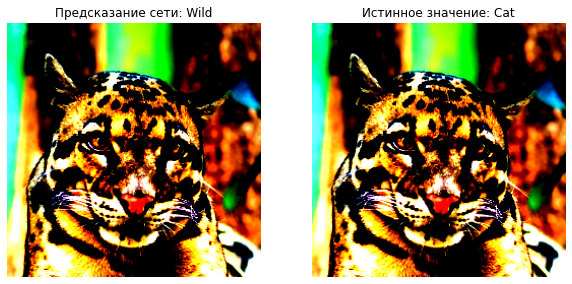

In [ ]:
plt.subplots(figsize=(10,10))


plt.subplot(1,2,1)
plt.title(f'Предсказание сети: {class_dict[current_label]}')
plt.imshow(np.squeeze(np.transpose(images_array_test[int(net_error_list[0])].numpy(),
                                               (1, 2, 0))), cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title(f'Истинное значение: {class_dict[int(labels_true[178])]}')
plt.imshow(np.squeeze(np.transpose(images_array_test[int(net_error_list[0])].numpy(),
                                               (1, 2, 0))), cmap='gray')
plt.axis('off')

plt.show()

Честно признаться, животное выше не очень похоже на домашнюю кошку)

Convnext относит это фото к животному из дикой природы, а не к кошкам, возможно это фото по ошибке попало в папку animal_faces/val/cat

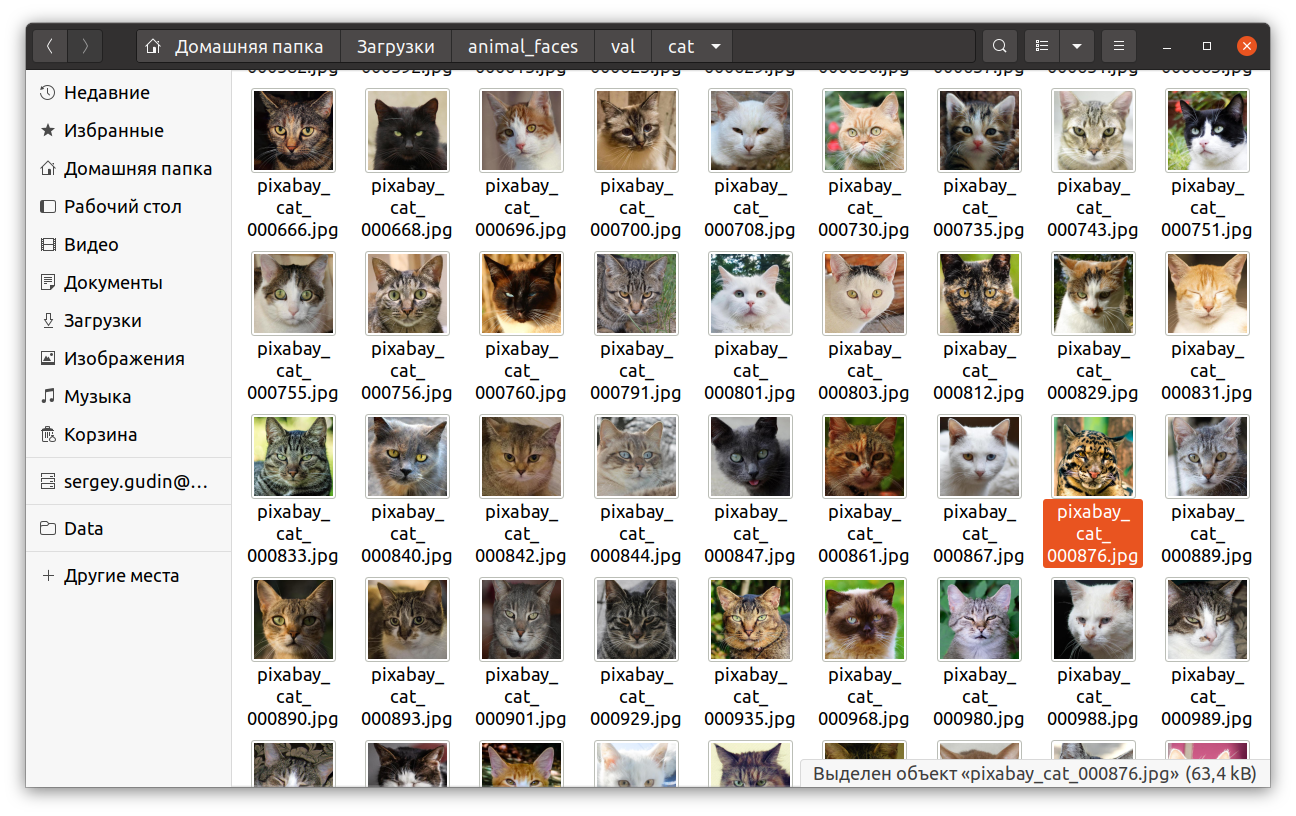